# Lane Detection Project

In this project we construct computer vision solution for a lane detection. We are going to implement one part of the [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper, namely Instance Segmentation.

We should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.



In [1]:
import os
import cv2
import json
import numpy as np
import torch

In [2]:
DEFAULT_SIZE = (256, 512)

In [3]:
!pip install kaggle
import os

os.makedirs('/home/23368999/.kaggle', exist_ok=True)

with open('/home/23368999/.kaggle/kaggle.json', 'w') as f:
    f.writelines('{"username":"zneron","key":"47c9371579baa64751f3de178eff25b2"}')
!kaggle datasets download -d manideep1108/tusimple

!mkdir data
!unzip -qq tusimple.zip -d data/tusimple

Dataset URL: https://www.kaggle.com/datasets/manideep1108/tusimple
License(s): copyright-authors
100% 21.6G/21.6G [04:34<00:00, 100MB/s]
100% 21.6G/21.6G [04:34<00:00, 84.6MB/s]


In [4]:
from torch.utils.data import Dataset
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size

        if self._mode == "train":
            annotation_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        else:
            annotation_files = [
                os.path.join(self._dataset_path, f"label_data_0601.json")
            ]

        self._data = []
        for annotation_file in annotation_files:
            self._process_label_file(annotation_file)

    def __getitem__(self, idx):
        img_path = os.path.join(self._dataset_path, self._data[idx][0])
        raw_img = cv2.imread(img_path)
        height, width, channels = raw_img.shape

        # Process input image
        processed_img = cv2.resize(raw_img, self._image_size, interpolation=cv2.INTER_LINEAR)
        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)[..., None]

        # Get road markings
        road_markings = self._data[idx][1]

        # Generate masks
        seg_mask = self._draw(height, width, road_markings, "segmentation")
        inst_mask = self._draw(height, width, road_markings, "instance")
        inst_mask = inst_mask[..., None]

        # Convert to tensors
        img_tensor = torch.from_numpy(processed_img).float().permute((2, 0, 1))
        seg_tensor = torch.from_numpy(seg_mask.copy()).to(torch.int64)
        inst_tensor = torch.from_numpy(inst_mask.copy()).permute((2, 0, 1))

        return img_tensor, seg_tensor, inst_tensor

    def __len__(self):
        return len(self._data)

    def _draw(self, height, width, road_markings, mask_type):
        canvas = np.zeros((height, width), dtype=np.uint8)
        for mark_idx, marking in enumerate(road_markings):
            mark_color = 1 if mask_type == "segmentation" else mark_idx + 1
            cv2.polylines(canvas, [marking], False, mark_color, 10)

        resized_canvas = cv2.resize(canvas, self._image_size, interpolation=cv2.INTER_NEAREST)
        return resized_canvas

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                annotation = json.loads(line)
                img_file = annotation["raw_file"]
                markers = annotation["lanes"]
                height_samples = annotation["h_samples"]

                marker_coordinates = []
                for marker in markers:
                    x_coords = np.array([marker]).T
                    y_coords = np.array([height_samples]).T
                    combined_coords = np.hstack((x_coords, y_coords))
                    valid_indices = np.where(combined_coords[:, 0] > 0)
                    valid_coords = combined_coords[valid_indices]
                    marker_coordinates.append(valid_coords)

                self._data.append((img_file, marker_coordinates))

In [5]:
image, segmentation_image, instance_image = LaneDataset('/content/data/tusimple/TUSimple/train_set', size=DEFAULT_SIZE)[0]

In [6]:
image.shape, segmentation_image.shape, instance_image.shape

(torch.Size([1, 512, 256]), torch.Size([512, 256]), torch.Size([1, 512, 256]))

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In [7]:
import torch.nn as nn
class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.

    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)

In [8]:
class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.

    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

In [9]:
class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.

    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.

    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


In [10]:
class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.

    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.

    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.

    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.

    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


In [11]:
class ENet(nn.Module):
    """Generate the ENet model.

    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.

    """

    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

        self.upsample5_0_1 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv_1 = nn.ConvTranspose2d(
            16,
            4,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)



    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x_4_2 = self.regular4_2(x)

        # Stage 5 - Decoder
        x_binary = self.upsample5_0(x_4_2, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular5_1(x_binary)
        x_binary = self.transposed_conv(x_binary, output_size=input_size)

        x_emb = self.upsample5_0_1(x_4_2, max_indices1_0, output_size=stage1_input_size)
        x_emb = self.regular5_1_1(x_emb)
        x_emb = self.transposed_conv_1(x_emb, output_size=input_size)

        return x_binary, x_emb

In [12]:
enet_model = ENet(2,4)

In [13]:
enet_model(torch.ones(1, 1, 512, 256))[0].shape, enet_model(torch.ones(1, 1, 512, 256))[1].shape

(torch.Size([1, 2, 512, 256]), torch.Size([1, 4, 512, 256]))

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [14]:
import torch.nn as nn

class DiscriminativeLoss(nn.Module):
    def __init__(self, delta_var=0.5, delta_dist=3, norm=2, alpha=1.0, beta=1.0, gamma=0.001, device='cpu', reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__()
        assert norm in [1,2]
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = device
        self.reduction = reduction
        self.n_clusters = n_clusters

    def forward(self, input, target):
        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples = target.size(0)
        var_loss, dis_loss, reg_loss = 0, 0, 0

        for i in range(num_samples):
            sample_embedding = input[i].view(-1, input.size(1) * input.size(2))
            sample_label = target[i].view(-1).squeeze()
            unique_labels = sample_label.unique()[1:]

            cluster_means = []
            for label in unique_labels:
                indices = (sample_label == label).nonzero(as_tuple=False).squeeze()
                if indices.numel() == 0:
                    continue

                indices = indices[indices < sample_embedding.size(1)]

                if indices.numel() == 0:
                    continue

                cluster_elements = sample_embedding.index_select(0, indices)
                mean_cluster = cluster_elements.mean(dim=0)
                cluster_means.append(mean_cluster)

                var_loss += self._variance_loss(cluster_elements, mean_cluster)

            if len(cluster_means) > 1:
                dis_loss += self._distance_loss(cluster_means)
            reg_loss += self._regularization_loss(cluster_means)

        avg_var_loss = var_loss / num_samples
        avg_dis_loss = dis_loss / (num_samples * max(len(unique_labels) - 1, 1))
        avg_reg_loss = reg_loss / num_samples

        return self.alpha * avg_var_loss * self.beta * avg_dis_loss * self.gamma * avg_reg_loss

    def _variance_loss(self, elements, mean):
        return torch.pow((torch.clamp(torch.norm(elements - mean) - self.delta_var, min = 0.)), 2).sum() / elements.sum()

    def _distance_loss(self, cluster_means):
        loss = 0
        for i, mean_i in enumerate(cluster_means):
            for mean_j in cluster_means[i+1:]:
                distance = torch.norm(mean_i - mean_j)
                loss += torch.pow(torch.cla&p(self.delta_dist - distance, min = 0.), 2)
        return loss

    def _regularization_loss(self, cluster_means):
        return sum(torch.sum(torch.abs(mean)) for mean in cluster_means)

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [15]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = torch.nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cuda:0")
    instance_loss = ds_loss(instance_output, instance_label)

    return binary_loss, instance_loss

In [16]:
compute_loss(torch.ones([32, 2, 512, 256], dtype = torch.float32), torch.ones([32, 4, 512, 256], dtype = torch.float32),
             torch.ones([32, 512, 256], dtype = torch.int64), torch.ones([32, 1, 512, 256], dtype = torch.int64))

(tensor(0.6931), 0.0)

In [17]:
!pip install pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 43.0 MB/s eta 0:00:00


In [18]:
class LitEnet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.enet = ENet(2, 4)

        self.binary_loss_metric = torchmetrics.MeanMetric()
        self.instance_loss_metric = torchmetrics.MeanMetric()
        self.jaccard_index = torchmetrics.JaccardIndex(task="multiclass", num_classes=2)
        self.accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.enet(x)

    def training_step(self, batch_data, batch_idx):
        images, binary_targets, instance_targets = batch_data
        instance_targets = instance_targets.type(torch.int64)

        binary_logits, instance_embeddings = self(images / 255)
        binary_loss, instance_loss = compute_loss(binary_logits, instance_embeddings, binary_targets, instance_targets)
        total_loss = binary_loss - instance_loss

        self.binary_loss_metric(binary_loss)
        self.instance_loss_metric(instance_loss)
        self.jaccard_index(binary_logits.argmax(dim=1), binary_targets)
        self.accuracy_metric(binary_logits.argmax(dim=1), binary_targets)

        self.log("train_loss", total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_binary_loss", binary_loss, on_step=False, on_epoch=True)
        self.log("train_instance_loss", instance_loss, on_step=False, on_epoch=True)

        return total_loss

    def on_train_epoch_end(self):
        self.log("epoch_avg_binary_loss", self.binary_loss_metric.compute(), on_epoch=True, prog_bar=True)
        self.log("epoch_instance_loss", self.instance_loss_metric.compute(), on_epoch=True, prog_bar=True)
        self.log("epoch_jaccard_index", self.jaccard_index.compute(), on_epoch=True, prog_bar=True)
        self.log("epoch_accuracy", self.accuracy_metric.compute(), on_epoch=True, prog_bar=True)

        self.binary_loss_metric.reset()
        self.instance_loss_metric.reset()
        self.jaccard_index.reset()
        self.accuracy_metric.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
        return optimizer

    def train_dataloader(self):
        train_dataset = LaneDataset('/content/data/tusimple/TUSimple/train_set', size=DEFAULT_SIZE)
        return DataLoader(train_dataset, batch_size=32, num_workers=10, shuffle=True)

In [19]:
# Checkpoint and Early Stopping Callbacks
checkpoint_callback = ModelCheckpoint(monitor="train_loss")
early_stopping = EarlyStopping(monitor="epoch_jaccard_index", patience=10)


# Initialize Model and Trainer
model = LitEnet()

trainer = pl.Trainer(
        max_epochs=30,
        devices=1,
        callbacks=[checkpoint_callback, early_stopping]
    )

trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type                   | Params | Mode 
------------------------------------------------------------------------
0 | enet                 | ENet                   | 353 K  | train
1 | binary_loss_metric   | MeanMetric             | 0      | train
2 | instance_loss_metric | MeanMetric             | 0      | train
3 | jaccard_index        | MulticlassJaccardIndex | 0      | train
4 | accuracy_metric      | MulticlassAccuracy     | 0      | train
------------------------------------------------------------------------
353 K     Trainable params
0         Non-trainable params
353 K     Total pa

Training: |          | 0/? [00:00<?, ?it/s]

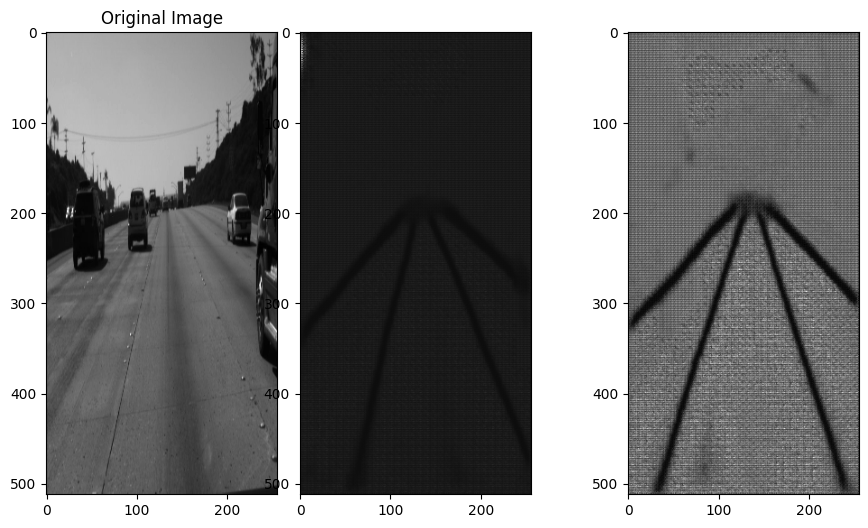

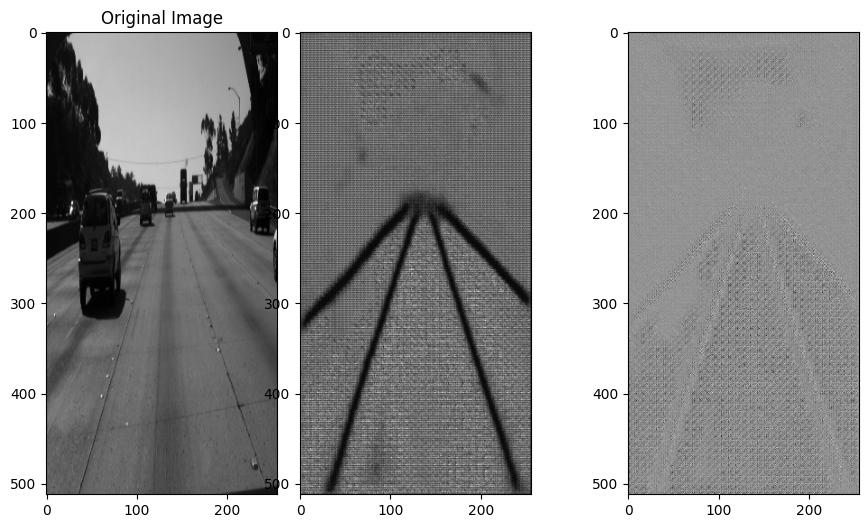

In [20]:
import matplotlib.pyplot as plt

train_dataset = LaneDataset('data/tusimple/TUSimple/train_set', train='val', size=DEFAULT_SIZE)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)

images, _, _ = next(iter(train_loader))

# Model prediction
with torch.no_grad():
    outputs = model(images / 255)

for i in range(len(images)):
    img = images[i].squeeze().numpy()
    output = outputs[0][i].numpy().squeeze()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(output[0], cmap='gray')

    plt.subplot(1, 3, 3)
    output = outputs[i][1].cpu().numpy().squeeze()
    plt.imshow(output[0], cmap='gray')

plt.show()